# **ANN**

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net, visualize_decision_boundary
from scipy import stats
import pandas as pd



#### Load data

In [2]:
filename = 'heart_failure_clinical_records_dataset.csv'
df = pd.read_csv(filename)
raw_data = df.values

cols = range(0, 12)

X = raw_data[:, cols]

attributeNames = np.asarray(df.columns[cols])
attribute_dic = dict(zip(attributeNames, range(len(attributeNames))))

# Our class labels is DEATH 
classLabels = raw_data[:, -1]
classNames = sorted(set(classLabels))
classDic = dict(zip(classNames, range(len(classNames))))
y = np.array([classDic[i] for i in classLabels])
y = y.reshape(299,1)
N, M = X.shape
C = len(classNames)

Training model of type:

Sequential(
  (0): Linear(in_features=12, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/5

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.34919563	0.00016025342
		2000	0.3219153	4.4342967e-05
		3000	0.312335	2.0037338e-05
		4000	0.307418	1.3087266e-05
		5000	0.30356523	1.2664332e-05
		6000	0.29958394	1.3926871e-05
		7000	0.29501376	1.575889e-05
		8000	0.2905713	1.4461396e-05
		9000	0.28685948	1.1843515e-05
		10000	0.28390923	9.342359e-06
		Final loss:
		10000	0.28390923	9.342359e-06

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.37729037	0.00025033692
		2000	0.3336435	8.967311e-05
		3000	0.3170636	3.8160422e-05
		4000	0.3072318	2.6772035e-05
		5000	0.30032277	1.8953393e-05
		6000	0.29504374	1.6363327e-05
		7000	0.2906855	1.4763278e-05
		8000	0.28688595	1.09075045e-05
		9000	0.28366497	1.0506059e-05
		10000	0.28097907	9.333719e-06
		Final loss:
		10000	0.28097907

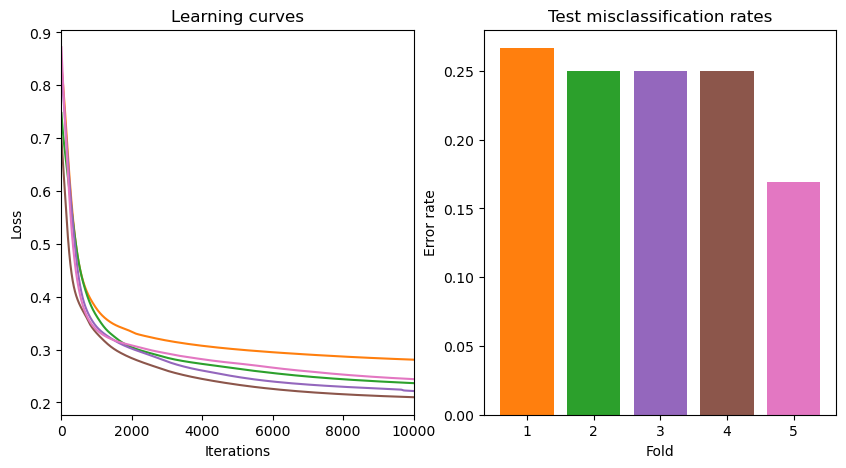

In [3]:
# Normalize data
X = stats.zscore(X);

# Parameters for neural network classifier
n_hidden_units = 2     # number of hidden units
n_replicates = 2        # number of networks trained in each k-fold
max_iter = 10000         # stop criterion 2 (max epochs in training)

# K-fold crossvalidation
K = 5                   # only five folds to speed up this example
CV = model_selection.KFold(K, shuffle=True)
# Make figure for holding summaries (errors and learning curves)
summaries, summaries_axes = plt.subplots(1,2, figsize=(10,5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']

# Define the model, see also Exercise 8.2.2-script for more information.
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
loss_fn = torch.nn.BCELoss()

print('Training model of type:\n\n{}\n'.format(str(model())))
errors = [] # make a list for storing generalizaition error in each loop
for k, (train_index, test_index) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.Tensor(X[train_index,:])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index,:])
    y_test = torch.Tensor(y[test_index])
    
    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=n_replicates,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_sigmoid = net(X_test)
    y_test_est = (y_sigmoid>.5).type(dtype=torch.uint8)

    # Determine errors and errors
    y_test = y_test.type(dtype=torch.uint8)

    e = y_test_est != y_test
    error_rate = (sum(e).type(torch.float)/len(y_test)).data.numpy()
    errors.append(error_rate) # store error rate for current CV fold 
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')
    
# Display the error rate across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold');
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('Error rate');
summaries_axes[1].set_title('Test misclassification rates')

print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,3]]
# draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print('\nGeneralization error/average error rate: {0}%'.format(round(100*np.mean(errors),4)))

Training model of type:
Sequential(
  (0): Linear(in_features=13, out_features=1, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/4

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.112168536	0.0010734393
		2000	0.047602482	0.0007045325
		3000	0.025525993	0.00056214066
		4000	0.015095415	0.00049652735
		5000	0.009365382	0.00046189863
		6000	0.0059611527	0.00044279956
		7000	0.0038492556	0.00043320295
		8000	0.0025062857	0.00042724423
		9000	0.0016399435	0.00042184207
		10000	0.0010762507	0.00041897336
		Final loss:
		10000	0.0010762507	0.00041897336

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.20825909	0.0010988174
		2000	0.087015666	0.0007080323
		3000	0.046621945	0.0005616508
		4000	0.027574765	0.0004961706
		5000	0.017110195	0.00046125194
		6000	0.010893512	0.00044300107
		7000	0.0070370403	0.00043238513
		8000	0.004584458	0.0004253121
		9000	0.0030017304	0.0004215457
		10000	0.0019714409	0.0004193215

NameError: name 'attributeNames' is not defined

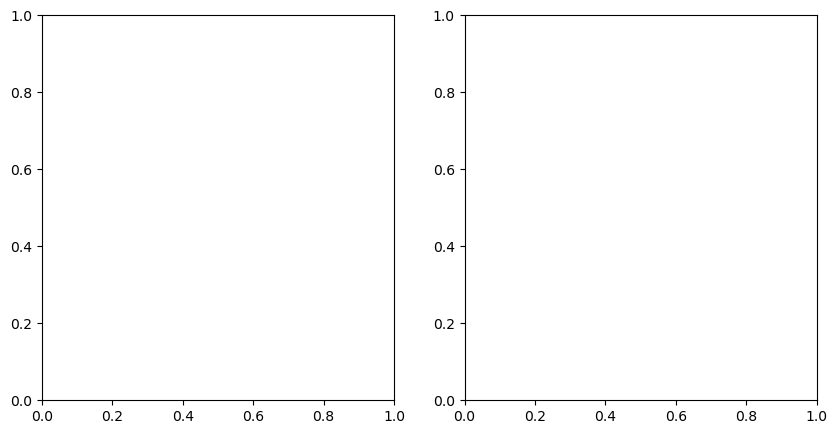

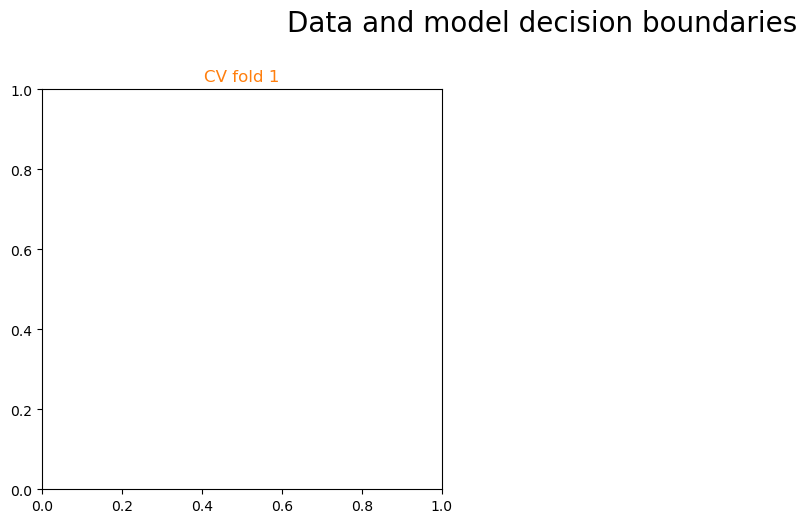

In [18]:
# K-fold CrossValidation (4 folds here to speed up this example)
K = 4
CV = model_selection.KFold(K,shuffle=True)

# Setup figure for display of the decision boundary for the several crossvalidation folds.
decision_boundaries = plt.figure(1, figsize=(10,10))
# Determine a size of a plot grid that fits visualizations for the chosen number
# of cross-validation splits, if K=4, this is simply a 2-by-2 grid.
subplot_size_1 = int(np.floor(np.sqrt(K))) 
subplot_size_2 = int(np.ceil(K/subplot_size_1))
# Set overall title for all of the subplots
plt.suptitle('Data and model decision boundaries', fontsize=20)
# Change spacing of subplots
plt.subplots_adjust(left=0, bottom=0, right=1, top=.9, wspace=.5, hspace=0.25)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10,5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']

# Define the model structure
n_hidden_units = 1 # number of hidden units in the signle hidden layer
# The lambda-syntax defines an anonymous function, which is used here to 
# make it easy to make new networks within each cross validation fold
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
# Since we're training a neural network for binary classification, we use a 
# binary cross entropy loss (see the help(train_neural_net) for more on
# the loss_fn input to the function)
loss_fn = torch.nn.BCELoss()
# Train for a maximum of 10000 steps, or until convergence (see help for the 
# function train_neural_net() for more on the tolerance/convergence))
max_iter = 10000
print('Training model of type:\n{}\n'.format(str(model())))

# Do cross-validation:
errors = [] # make a list for storing generalizaition error in each loop
# Loop over each cross-validation split. The CV.split-method returns the 
# indices to be used for training and testing in each split, and calling 
# the enumerate-method with this simply returns this indices along with 
# a counter k:
for k, (train_index, test_index) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, 
    # and convert them to PyTorch tensors
    X_train = torch.Tensor(X[train_index,:] )
    y_train = torch.Tensor(y[train_index] )
    X_test = torch.Tensor(X[test_index,:] )
    y_test = torch.Tensor(y[test_index] )
    
    # Go to the file 'toolbox_02450.py' in the Tools sub-folder of the toolbox
    # and see how the network is trained (search for 'def train_neural_net',
    # which is the place the function below is defined)
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=3,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_sigmoid = net(X_test) # activation of final note, i.e. prediction of network
    y_test_est = (y_sigmoid > .5).type(dtype=torch.uint8) # threshold output of sigmoidal function
    y_test = y_test.type(dtype=torch.uint8)
    # Determine errors and error rate
    e = (y_test_est != y_test)
    error_rate = (sum(e).type(torch.float)/len(y_test)).data.numpy()
    errors.append(error_rate) # store error rate for current CV fold 
    
    # Make a subplot for current cross validation fold that displays the 
    # decision boundary over the original data, "background color" corresponds
    # to the output of the sigmoidal transfer function (i.e. before threshold),
    # white areas are areas of uncertainty, and a deaper red/blue means 
    # that the network "is more sure" of a given class.
    plt.figure(decision_boundaries.number)
    plt.subplot(subplot_size_1,subplot_size_2,k+1)
    plt.title('CV fold {0}'.format(k+1),color=color_list[k])
    predict = lambda x: net(torch.tensor(x, dtype=torch.float)).data.numpy()
    visualize_decision_boundary(predict, X, y, # provide data, along with function for prediction
                                attributeNames, classNames, # provide information on attribute and class names
                                train=train_index, test=test_index, # provide information on partioning
                                show_legend=k==(K-1)) # only display legend for last plot
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')
    
# Display the error rate across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold');
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('Error rate');
summaries_axes[1].set_title('Test misclassification rates')
    
# Show the plots
# plt.show(decision_boundaries.number) # try these lines if the following code fails (depends on package versions)
# plt.show(summaries.number)
plt.show()

# Display a diagram of the best network in last fold
print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,3]]
draw_neural_net(weights, biases, tf)

# Print the average classification error rate
print('\nGeneralization error/average error rate: {0}%'.format(round(100*np.mean(errors),4)))